###Table of Contents
1. <a href = #Objective>Objective</a>
2. <a href = #Exploration-Notes>Exploration Notes</a>
3. <a href = #Processing-Steps>Processing Steps</a>
4. <a href = #Visualizations>Visualizations</a>
5. <a href = #Next-Steps>Next Steps</a>

#Objective
    1. Use cases
    2. Challenge to self
    3. Inference

#Exploration Notes

Using company-purchased public-record county assessment data from 2009, focused only on the Bay Area. This provides information on all homes (including off-market) at that time. Practically, we use this as a base, then add on individual home sales since 2009 to populate the data on our home-detail pages.

In [1]:
import pandas as pd
example = pd.read_csv('data_example.csv', index_col = 'Unnamed: 0', dtype = 'object')

sort_order = {'ZIP': 1, 'FIDELITY_LATITUDE': 2, 'FIDELITY_LONGITUDE': 3,
              'ASSESSED_LAND_VALUE': 4, 'ASSESSED_TOTAL_VALUE': 5, 'ASSESSED_IMP_VALUE': 6,
              'BED': 7, 'BATH': 8, 'BUILDING_AREA': 9, 'LOT_SIZE': 10, 'PARKING': 11,
              'PROPERTY_TYPE': 12, 'LAND_USE': 13, 'AGE': 14, 'STORIES': 15, 'TOTAL_UNITS': 16,
              'GARAGE_TYPE': 17, 'POOL': 18, 'FIREPLACE': 19}

sort_order = pd.Series(sort_order, name = 'rk')
example = pd.concat([example, sort_order], axis = 1).sort('rk')
del example['rk']
example

,0,1,2,3,4
ZIP,94607,94607,94607,94607,94607
FIDELITY_LATITUDE,37.803152000000004,37.803141,37.803136,37.803125,37.803093
FIDELITY_LONGITUDE,-122.296821,-122.29676699999999,-122.29673999999999,-122.29668500000001,-122.296523
ASSESSED_LAND_VALUE,15464.0,90000.0,17487.0,27290.0,18193.0
ASSESSED_TOTAL_VALUE,46393.0,210000.0,125805.0,56096.0,37903.0
ASSESSED_IMP_VALUE,61857.0,300000.0,143292.0,83386.0,56096.0
BED,2,2,4,4,4
BATH,1.0,0.5,2.0,1.5,2.0
BUILDING_AREA,572,572,1672,1144,1594
LOT_SIZE,2500.0,2500.0,2500.0,2500.0,2500.0


In [2]:
base = pd.read_csv('base.csv', index_col = 'Unnamed: 0') # read data in, change to base_s.csv if no access

C:\Users\dfeng\AppData\Local\Continuum\Anaconda\lib\site-packages\pandas\io\parsers.py:1130: DtypeWarning: Columns (8,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [3]:
# Errors
for i in base.columns:
    if len(base[base[i].isnull()]) > 0:
        print i + ': {}'.format(len(base[base[i].isnull()]))

AGE: 91851
STORIES: 500500
GARAGE_TYPE: 405435
POOL: 1426877
FIREPLACE: 1342550
PROPERTY_TYPE: 1485611


In [4]:
# Zeros
for i in base.columns:
    if (base[i]==0).sum() > 0:
        print i + ': ' + str((base[i] == 0).sum())

ASSESSED_LAND_VALUE: 1694
ASSESSED_TOTAL_VALUE: 41902
ASSESSED_IMP_VALUE: 1669
BATH: 98502
BED: 180468
AGE: 486
PARKING: 650849
TOTAL_UNITS: 1314170
BUILDING_AREA: 73916
FIDELITY_LATITUDE: 9081
FIDELITY_LONGITUDE: 9081


#Processing Steps

In [5]:
lu_ptype = {
            1001 : 'SFR',
            1002 : 'TOWNHOUSE',
            1003 : 'CLUSTER HOME',
            1004 : 'CONDO',
            1005 : 'COOP',
            1006 : 'MOBILE',
            1007 : 'ROW HOUSE',
            1009 : 'SFR-PUD',
            1101 : 'MFR',
            1102 : 'MFR',
            1103 : 'MFR',
            1110 : 'MFR'
            }

base['ptype'] = base.LAND_USE.map(lu_ptype)

basef = base

basef = basef[basef.ASSESSED_TOTAL_VALUE > 0] # remove Land
basef = basef[basef.FIDELITY_LATITUDE > 0] # remove properties with no lat/long information
basef = basef[basef.ASSESSED_LAND_VALUE > 0] # remove properties with no land value
basef = basef[basef.BUILDING_AREA > 0] # remove properties with no land value
basef = basef[basef.BED > 0]
basef = basef[basef.BATH > 0]
basef = basef[basef.STORIES > 0]

basef2 = basef

basef2 = basef2[basef2.AGE.notnull()]
basef2 = basef2[basef2.ptype.notnull()]
basef2 = basef2[basef2.STORIES.notnull()]

basef2 = basef2[basef2.STORIES != 'S/L']
basef2.STORIES = basef2.STORIES.replace(r'\+B*', '', regex = True)
basef2.STORIES = basef2.STORIES.astype(float)

# looks like lot size has mixed units (feet, acres): I'll attempt to convert acres to feet using the following rule:
basef2['lsize_sqft'] = basef2.LOT_SIZE.apply(lambda x: x * 43560 if x < 100 and x < basef2.BUILDING_AREA.iteritems() else x)

basef2['landval_perc'] = basef2.ASSESSED_LAND_VALUE / basef2.ASSESSED_IMP_VALUE
basef2['lot_perc'] = 1 - basef2.BUILDING_AREA / basef2.lsize_sqft

basef2 = basef2[basef2.lot_perc >= -0.1]
basef2 = basef2[basef2.PARKING <= 10]
basef2 = basef2[basef2.TOTAL_UNITS < 3.5]
basef2 = basef2[basef2.STORIES < 4.5]
len(basef2)

869044

    1. Mapped LAND_USE to ptype
    2. Normalized LOT_SIZE to sq feet by assuming it's in acres if it's < 100 (see 3a)
    3. Created lot_perc (% of lot size that is not-building) and landval_perc (ASSESSED_LAND_VALUE/ASSESSED_IMP_VALUE)
        a. Removed cases where BUILDING_AREA was bigger than LOT_SIZE by > 10% (49860)
    4. Stripped out '+B' appendage in STORIES (e.g. 2+B)
    5. Removed records with:
       a. ASSESSED_TOTAL_VALUE == 0 (41902) -- Land-only parcels
       b. ASSESSED_LAND_VALUE == 0 (1694)
       c. FIDELITY_LATITUDE == 0 (9081) -- no lat/long info
       d. BUILDING_AREA == 0 (73916)
       e. BED == 0 (180468)
       f. BATH == 0 (98502)
       g. STORIES == 0 (small) -- Santa Barbara case
       h. AGE NaNs (91851)
       i. ptype NaNs (20849) -- likely Land or Commercial
       j. STORIES NaNs (500500) -- was conflated with something else
       k. PARKING > 10 -- probably sq ft
    6. After scaling data, determined STORIES and TOTAL_UNITS need more pruning
       a. Removed anything above 5 standard deviations from the mean -- what are you still doing in here??
        
Started with 1558278 records, ended with 866945

###PCA
Does not look easily reducible
<img src = 'pca.png'>
Note: Did not include ptype (a categorical variable) in the PCA

#Visualizations

In [6]:
from mpl_toolkits.basemap import Basemap
%matplotlib inline
from seaborn import plt

bayarea  = Basemap(projection='merc', lat_0=((37.2056+38.385)/2), lon_0 = ((-122.791-121.667)/2),
                   llcrnrlat = 37.205572, llcrnrlon = -122.791252,
                   urcrnrlat = 38.385387, urcrnrlon = -121.667213,
                   resolution = 'h', area_thresh = 0.001)

sf = Basemap(projection='merc', lat_0=((37.7077+37.8339)/2), lon_0=((-122.511243-122.361039)/2),
             llcrnrlat = 37.707739, llcrnrlon = -122.511243,
             urcrnrlat = 37.833933, urcrnrlon = -122.361039,
             resolution = 'h', area_thresh = 0.001)

# northbay = Basemap()

# southbay = Basemap()

eastbay = Basemap(projection='merc', lat_0=((37.796+37.9026)/2), lon_0=((-122.318-122.204)/2),
                  llcrnrlat = 37.796372, llcrnrlon = -122.318089,
                  urcrnrlat = 37.902642, urcrnrlon = -122.204105,
                  resolution = 'h', area_thresh = 0.001)

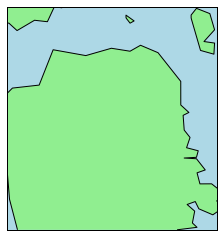

In [32]:
sf.drawcoastlines()
sf.drawmapboundary(fill_color = 'lightblue')
sf.fillcontinents(color = 'lightgreen')

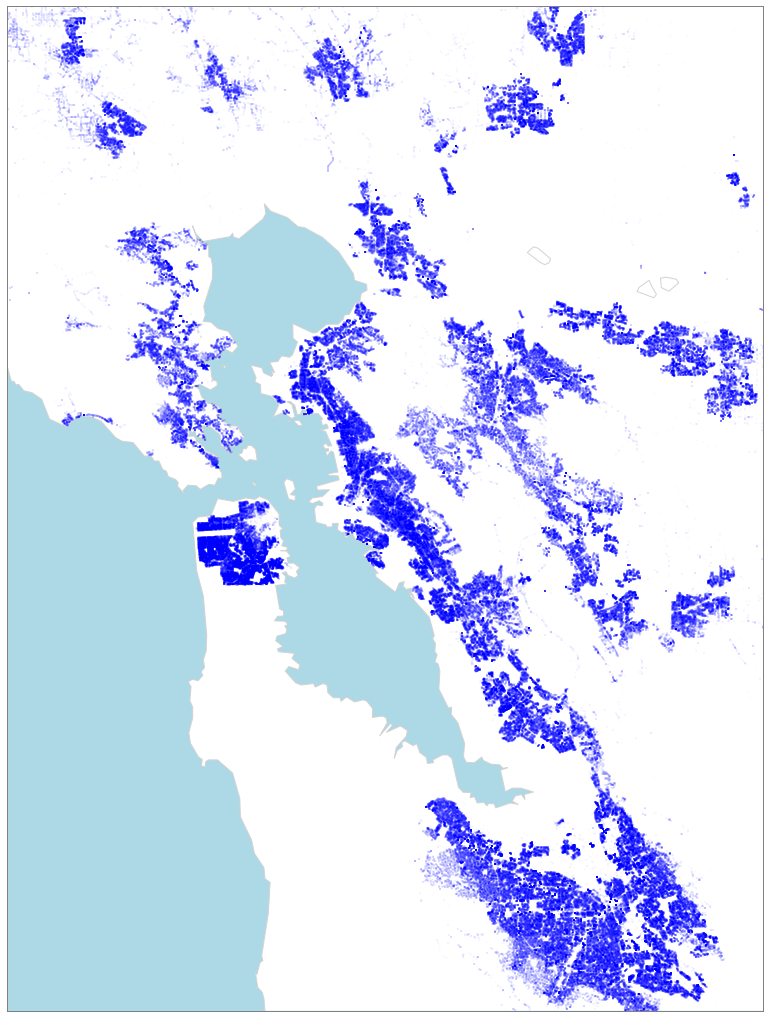

In [42]:























plt.figure(figsize=(18,18))
bayarea.drawcoastlines(color='lightgray')
bayarea.drawmapboundary(color='gray', fill_color = 'lightblue')
bayarea.fillcontinents(color = 'white')

lat = base.FIDELITY_LATITUDE.tolist()
lon = base.FIDELITY_LONGITUDE.tolist()
x,y = bayarea(lon,lat)

bayarea.plot(x, y, 'bo', markersize=1, alpha = 0.1)

plt.show()

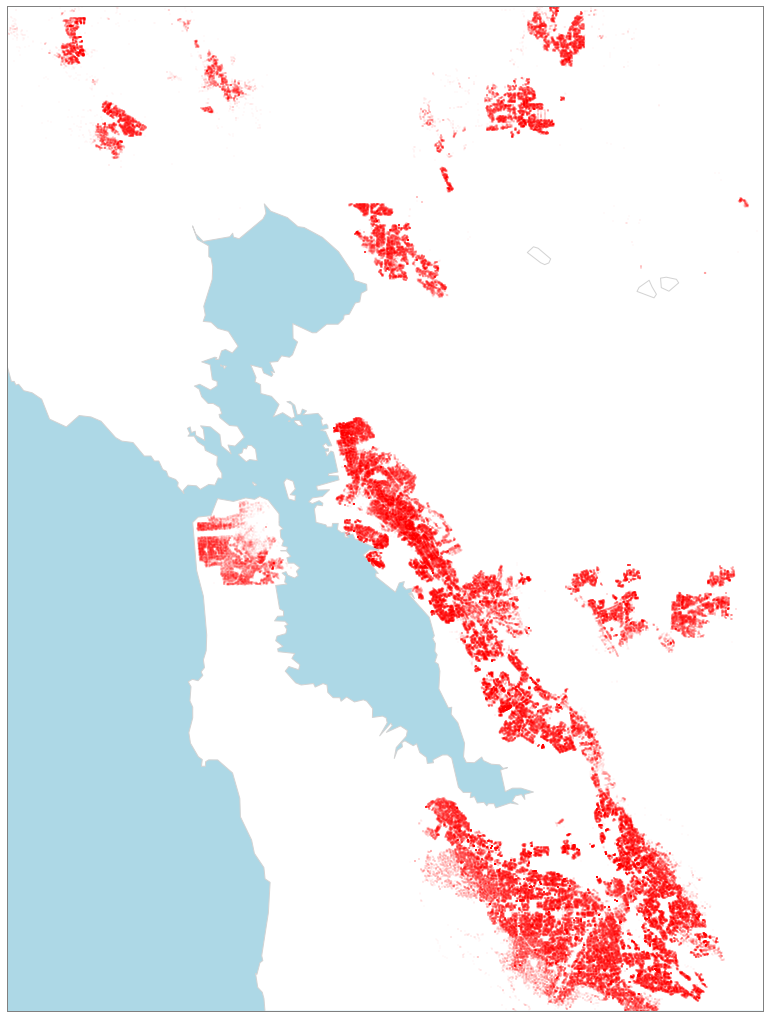

In [51]:
plt.figure(figsize=(18,18))
bayarea.drawcoastlines(color='lightgray')
bayarea.drawmapboundary(color='gray', fill_color = 'lightblue')
bayarea.fillcontinents(color = 'white')

lat = basef2.FIDELITY_LATITUDE.tolist()
lon = basef2.FIDELITY_LONGITUDE.tolist()
x,y = bayarea(lon,lat)

bayarea.plot(x, y, 'ro', markersize=1, alpha = 0.1)

# bayarea.drawlsmask(ocean_color = 'navy', resolution = 'h')

plt.show()

1558278 869044 1558278


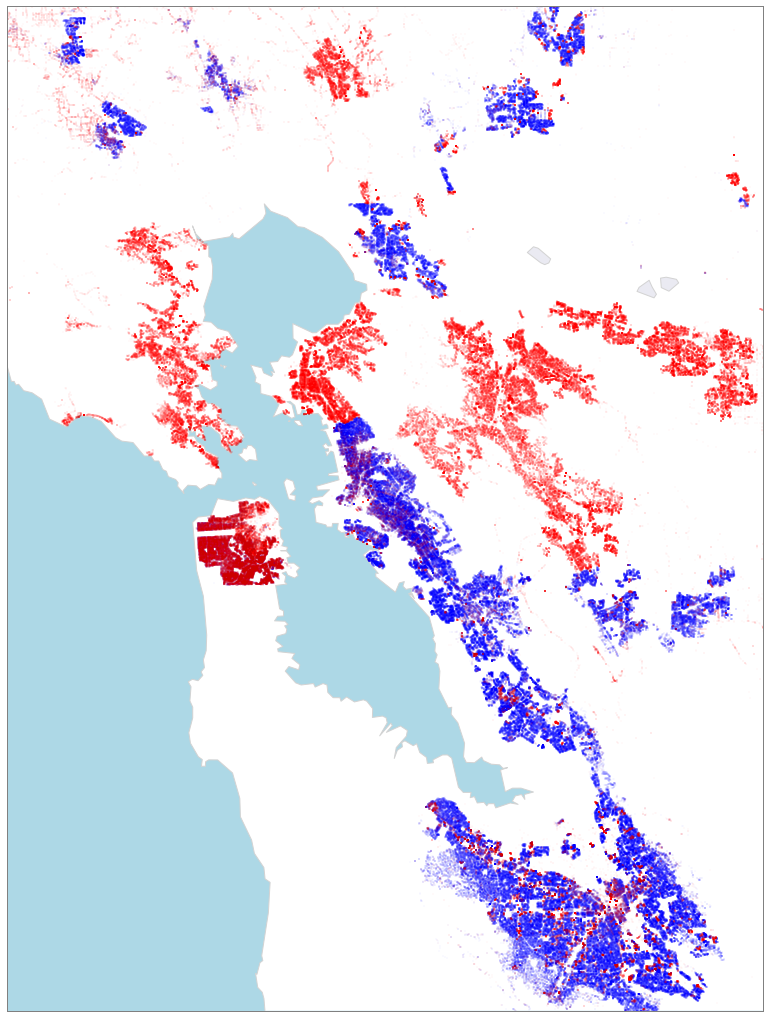

In [13]:
combined = pd.merge(base, basef2, how = 'left', left_index = True, right_index = True)
print len(base), len(basef2), len(combined)

plt.figure(figsize=(18,18))
bayarea.drawcoastlines(color='lightgray')
bayarea.drawmapboundary(color='gray', fill_color = 'lightblue')
bayarea.fillcontinents(color = 'white')

lat_orig = combined.FIDELITY_LATITUDE_x[combined.FIDELITY_LATITUDE_y.notnull()].tolist()
lon_orig = combined.FIDELITY_LONGITUDE_x[combined.FIDELITY_LONGITUDE_y.notnull()].tolist()
x_orig,y_orig = bayarea(lon_orig,lat_orig)

bayarea.plot(x_orig, y_orig, 'bo', markersize=1, alpha = 0.1)

lat_rem = combined.FIDELITY_LATITUDE_x[combined.FIDELITY_LATITUDE_y.isnull()].tolist()
lon_rem = combined.FIDELITY_LONGITUDE_x[combined.FIDELITY_LONGITUDE_y.isnull()].tolist()
x_rem,y_rem = bayarea(lon_rem,lat_rem)

bayarea.plot(x_rem, y_rem, 'ro', markersize=1, alpha = 0.1)

# bayarea.drawlsmask(ocean_color = 'navy', resolution = 'h')

plt.show()

<img src="kmeans.png">
<img src = "gridsearch.png">

#Next Steps
    1. Model improvements
        a. PARALLELIZE!!!
        b. Pipeline the clustering with SVC - not sure if possible
        c. Understand a good threshold for max_iter for SVC
    2. Clean up the map
        a. Add existing neighborhood, city, zip layers (faint gray outline)
        b. Remove the mesh when in the water
        c. Figure out legend when doing it ggplot/scatter style
    3. Additional features
        a. Use POOL, FIREPLACE, GARAGE
        b. Use Google Elevation API to add elevation as a feature
        c. Add restaurant, bar data layers